### Importing Libraries.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader
from torchvision.datasets import Caltech101
from torchvision.transforms import ToTensor, Resize, Compose
from torchsummary import summary
from tqdm import tqdm
from sklearn.model_selection import train_test_split

### Downloading the datasets.

In [2]:
# Downloading CIFAR10 dataset.
transform = Compose([
    Resize((128, 128)),  # Resize all images to 128x128
    ToTensor()           # Convert images to tensors
])

data = Caltech101('Caltech101', download = True, transform=transform)

train_data, test_data = train_test_split(data, test_size=0.2, shuffle= True, random_state=28)

print(len(train_data),len(test_data))

Files already downloaded and verified
6941 1736


### Checking an image.

0


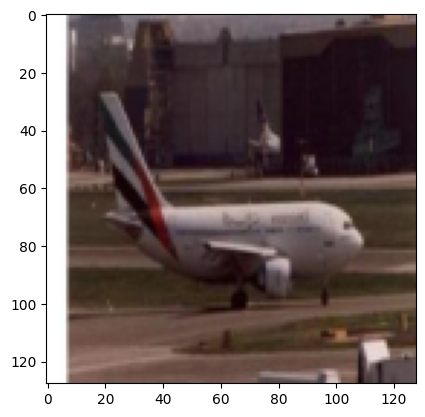

In [3]:
# Image label pairs.
print(train_data[0][1])
plt.imshow(test_data[10][0].permute(1,2,0))
plt.show()

### Creating a task set from the context and target points.

In [4]:
def get_context_target_sets(images_data, no_of_context_target_points,Image_shape):
    m,n = Image_shape

    # All coordinates of the image.
    All_coordinates = np.array([(i,j) for i in range (m) for j in range (n)])
    
    # Iterate on dataset to create context set and target set.
    task_set =  []
    for i in tqdm(range(len(images_data))):

        if images_data[i][0].shape[0]<3:
            continue

        image, _ = images_data[i]
        #image = image.squeeze()
        # Context point indexes
        context_idx = np.random.choice(range(len(All_coordinates)), no_of_context_target_points, replace = False)

        # Context points and corresponding pixel values.
        context_points = All_coordinates[context_idx]
        image = image.permute(1, 2, 0)
        context_pixels = image[context_points[:,0], context_points[:,1]]

        # Concatenating context points and corresponding pixel values.
        context_set = np.concatenate([context_points, context_pixels],axis=-1).astype(np.float32)

        # Giving pixel values for all pixels in image to predcit all the points given on grid .
        target_points = All_coordinates
        target_pixels = image[target_points[:,0], target_points[:,1]]
        
        # concatenate target points and corresponding pixel values.
        target_set = np.concatenate([target_points, target_pixels], axis = -1).astype(np.float32)
        task_set.append([context_set,target_set])
        
    return task_set

### Generating the train set.

In [5]:
train_set = get_context_target_sets(images_data=train_data, no_of_context_target_points=1000, Image_shape=(128,128))
train_dataloader = DataLoader(train_set, batch_size=8, shuffle= True)
for context_pairs,target_pairs in train_dataloader:
    print(context_pairs.shape, target_pairs.shape)
    # print(i.shape)
    break

  0%|          | 0/6941 [00:00<?, ?it/s]

100%|██████████| 6941/6941 [00:07<00:00, 888.93it/s] 

torch.Size([8, 1000, 5]) torch.Size([8, 16384, 5])


### Generating the test set.

In [6]:
test_set = get_context_target_sets(images_data=test_data, no_of_context_target_points=1000, Image_shape=(128,128))
test_dataloader = DataLoader(test_set, batch_size=8, shuffle= True)
for context_pairs, target_pairs in test_dataloader:
    print(context_pairs.shape, target_pairs.shape)
    break

100%|██████████| 1736/1736 [00:01<00:00, 918.60it/s] 

torch.Size([8, 1000, 5]) torch.Size([8, 16384, 5])


### Creating the Neural Process Class and defining the forward propagation, train and test functions.

In [12]:
class Neural_process_model(nn.Module):
    def __init__(self, device):
        super(Neural_process_model, self).__init__()
        if device == 'cuda':
            if torch.cuda.is_available():
                device = torch.device('cuda')
        else:
            device = torch.device('cpu')

        self.device = device
        
        self.encoder = nn.Sequential(
                                    nn.Linear(5,64),
                                    nn.ReLU(),
                                    nn.Linear(64,256),
                                    nn.ReLU(),
                                    # nn.Linear(128,256),
                                    # nn.ReLU(),
                                    nn.Linear(256, 512),
                                    # nn.ReLU(),
                                    # nn.Linear(512,512)
                                    )
        self.decoder = nn.Sequential(
                                    nn.Linear(512+2, 256),
                                    nn.ReLU(),
                                    # nn.Linear(512,256),
                                    # nn.ReLU(),
                                    nn.Linear(256,64),
                                    nn.ReLU(),
                                    # nn.Linear(128,64),
                                    # nn.ReLU(),
                                    nn.Linear(64,16),
                                    nn.ReLU(),
                                    # nn.Linear(32,16),
                                    # nn.ReLU(),
                                    nn.Linear(16,3)
                                    )
        
    def forward(self, context_pairs, target_pairs):
        latent_representation = self.encoder(context_pairs)
        # print(latent_representation)
        latent_representation = torch.mean(latent_representation, dim = 1)
        latent_representation = latent_representation.unsqueeze(1).repeat(1, target_pairs.size(1),1)

        # Cocatenating latent representation with target pixel locations.
        target_pixel_locations = target_pairs[:,:,:2]
        target = torch.cat([latent_representation, target_pixel_locations], dim = -1)

        # decode target pairs to obtain the predicted target pixel intensity
        predicted_target_pixel_intensity = self.decoder(target)
        
        return predicted_target_pixel_intensity
    
    def train(self, train_dataloader, num_epochs =100, optim = torch.optim.Adam, lr = 3e-4, criterion = nn.MSELoss(), verbose = True):
        device = self.device
        optimiser = optim(self.parameters(), lr = lr)
        for epoch in range(num_epochs):
            for _, (context_pairs, target_pairs) in enumerate(train_dataloader):
                context_pairs = context_pairs.to(device)
                target_pairs  = target_pairs.to(device)
                optimiser.zero_grad()
                predicted_target_pixel_intensity = self.forward(context_pairs, target_pairs)
                loss = criterion(predicted_target_pixel_intensity, target_pairs[:,:,2:])
                loss.backward()
                optimiser.step()
            if verbose:
                print("Epoch: {}/{} Loss: {:.5f}".format(epoch+1,num_epochs,loss.item()))

    def test(self, test_dataloader, criterion = nn.MSELoss()):
        device = self.device
        self.to(device)
        test_loss = 0
        with torch.no_grad():
            for i, context_pairs, target_pairs, in enumerate(test_dataloader):
                context_pairs = context_pairs.to(device)
                target_pairs  = target_pairs.to(device)
                predicted_target_pixel_intensity = self.forward(context_pairs, target_pairs)

            loss =  criterion(predicted_target_pixel_intensity, target_pairs[:,:,2:])
            test_loss += loss.item()
        print(f'Test Loss: {test_loss/len(test_dataloader)}')

### Checking the avialable device.

In [13]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

model = Neural_process_model(device = 'cuda')

cuda


### Training the model.

In [14]:
model.to(device)
model.train(train_dataloader, num_epochs=10)

Epoch: 1/10 Loss: 0.05343
Epoch: 2/10 Loss: 0.05247
Epoch: 3/10 Loss: 0.05835
Epoch: 4/10 Loss: 0.05998
Epoch: 5/10 Loss: 0.05117
Epoch: 6/10 Loss: 0.04953
Epoch: 7/10 Loss: 0.04321
Epoch: 8/10 Loss: 0.02450
Epoch: 9/10 Loss: 0.05988
Epoch: 10/10 Loss: 0.04335


### Testing the Neural Process.

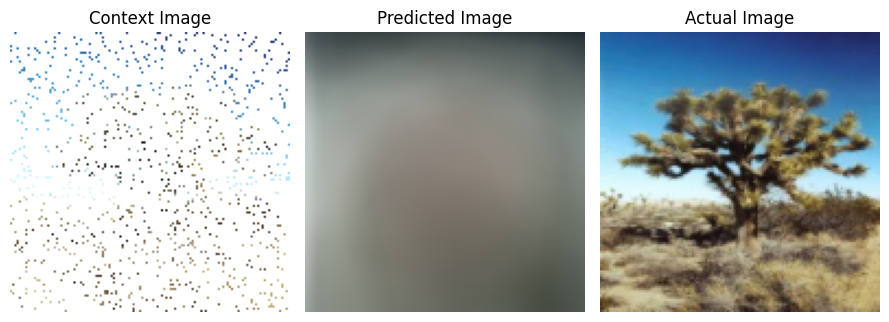

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.39193016..1.0531468].


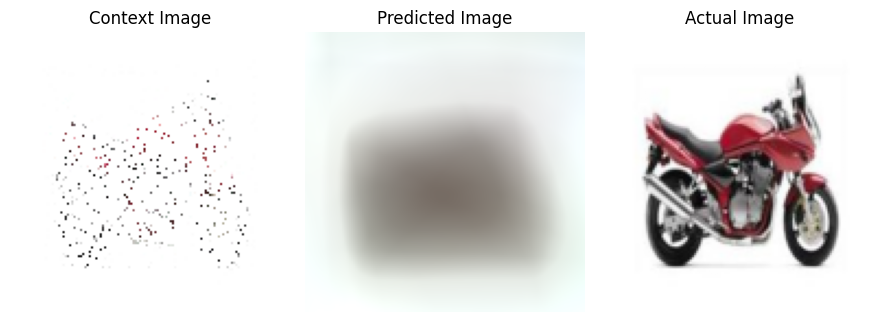

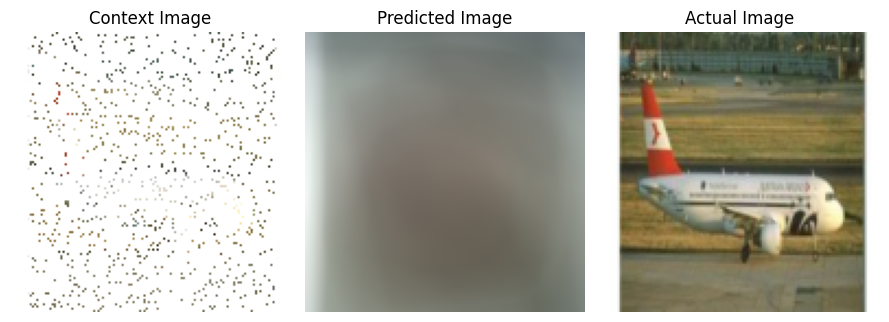

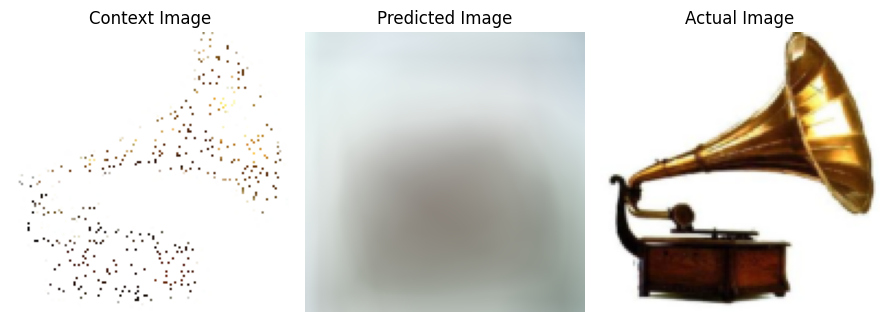

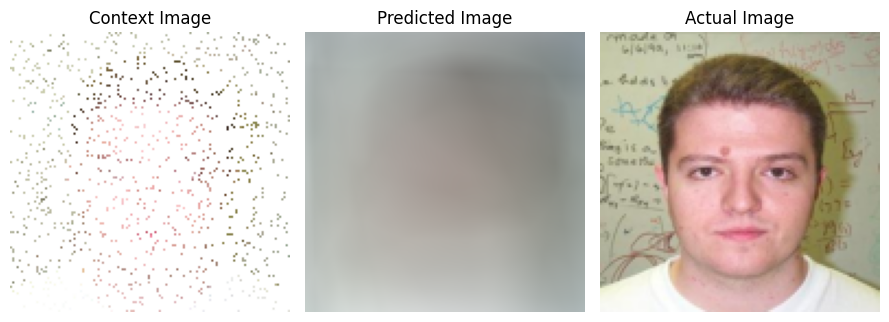

In [27]:
# testing the neural process.
for context_pairs, target_pairs in test_dataloader:
    context_pairs = context_pairs.to(device)
    target_pairs  = target_pairs.to(device)
    model.to(device)

    predicted_target_pixel_intensity = model(context_pairs, target_pairs)
    for i in range(5):
        predicted_pixel = predicted_target_pixel_intensity[i].detach().cpu().numpy()
        predicted_image = predicted_pixel.reshape(128,128,3)

        actual_pixel = target_pairs[i][:,2:].detach().cpu().numpy()
        actual_image = actual_pixel.reshape(128,128,3)

        context_image = np.ones((128,128,3))
        context_pixel_locations = context_pairs[i][:,:2].detach().cpu().numpy().astype(int)
        context_image[context_pixel_locations[:,0], context_pixel_locations[:,1]] = context_pairs[i][:,2:].detach().cpu().numpy()

        plt.figure(figsize=(9,4))

        plt.subplot(1,3,1)
        plt.imshow(context_image)
        plt.axis('off')
        plt.title('Context Image')
        
        plt.subplot(1,3,2)
        plt.imshow(predicted_image)
        plt.axis('off')
        plt.title('Predicted Image')

        plt.subplot(1,3,3)
        plt.imshow(actual_image)
        plt.axis('off')
        plt.title('Actual Image')
        
        plt.tight_layout()
        plt.show()

    break